# Parallel artificial membrane permeability assay (PAMPA) classification model

Parallel artificial membrane permeability assay (PAMPA) is an ADME assya and generally part of Tier-1 assay. This data set was obtained for Therapeutic data commons and from this article https://doi.org/10.1177/24725552211017520. This data set has got NCATS set - 2035 compounds. 

In [1]:
%cd ..

c:\Users\abhik\Documents\ML_projetcs


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, roc_auc_score, cohen_kappa_score

from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys, rdFingerprintGenerator
from rdkit.Chem import rdMolDescriptors #molecular descriptors

from utils import modelling_utils

C:\Users\abhik\AppData\Local\Temp\ipykernel_21708\1303976941.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
from tdc.single_pred import ADME
data = ADME(name = 'PAMPA_NCATS')


Found local copy...
Loading...
Done!


In [4]:
data_df = data.get_data()
data_df.columns = ["Name","SMILES","pampa"]

In [5]:
data_df.head()

,Name,SMILES,pampa
0,2466,CCCCOC1=CC=C(C=C1)CC(=O)NO,1
1,1259573,COC1=C(C=C(C=C1)CCN2C(=CC(=O)NC2=S)N)OC,0
2,1275864,COC1=C(C=C(C=C1)Cl)C(=O)NC2=CC=C(C=C2)NC(=O)C3...,1
3,4878,CC(C)(C)N1C2=NC=NC(=C2C(=N1)C3=CC=C(C=C3)Cl)N,1
4,2030130,CN1C2=CC=CC=C2C(=O)C3=C1N=C(N(C3=O)C4=CC=CC=C4...,1


<AxesSubplot:xlabel='pampa'>

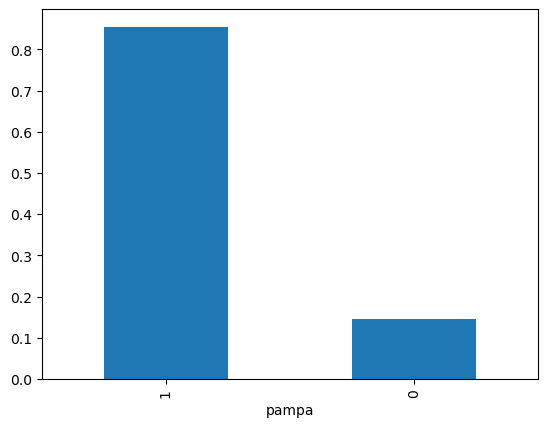

In [6]:
data_df.pampa.value_counts(normalize=True).plot(kind="bar")

The target column is highly imbalanced and we will resample it before trainign a model. 

## RdKit finger print as descriptor

In [7]:
def get_fp_rdkit(smiles: str) -> set:
    """Function to calculate MorganFingerprint from smiles.
    It returns index of all '1' bits of not-folded fingerprint.
    Args:
        smiles (str): smiles string
    Returns:
        set: return list of index of '1' bits.
    """

    mol = Chem.MolFromSmiles(smiles)

    if not mol:
        return

    fpg = rdFingerprintGenerator.GetMorganGenerator(radius=3)
    if not fpg:
        print(smiles)
        return

    return np.array(fpg.GetFingerprint(mol))

In [8]:
data_df['fp'] = data_df['SMILES'].apply(lambda x: get_fp_rdkit(x))

In [9]:
data_df.head()

,Name,SMILES,pampa,fp
0,2466,CCCCOC1=CC=C(C=C1)CC(=O)NO,1,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
1,1259573,COC1=C(C=C(C=C1)CCN2C(=CC(=O)NC2=S)N)OC,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,1275864,COC1=C(C=C(C=C1)Cl)C(=O)NC2=CC=C(C=C2)NC(=O)C3...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,4878,CC(C)(C)N1C2=NC=NC(=C2C(=N1)C3=CC=C(C=C3)Cl)N,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,2030130,CN1C2=CC=CC=C2C(=O)C3=C1N=C(N(C3=O)C4=CC=CC=C4...,1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [10]:
X = data_df.fp.to_list()

In [11]:
y = data_df['pampa'].to_list()

## Resampleing to handle imbalanced data set and train test split

In [12]:
sampling_strategy = 0.8
random_under_sampler = RandomUnderSampler(sampling_strategy=sampling_strategy)
X, y = random_under_sampler.fit_resample(X, y)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

In [15]:
log_reg = LogisticRegression("l2")

In [16]:
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.6515151515151515
0.675
0.7297297297297297
0.7012987012987013


## Hyperparameter tuning 

We wiil perform a hyperparamaetr tuning and evaluate the performaces of the best model using gridsearchCV. We will then check the performances of the best model on test data set. For these we will three custom made fucntions from modelling_utlis script in utils directory.

In [17]:
models = ["RandomForestClassifier", "GradientBoostingClassifier", "DecisionTreeClassifier"]
results = modelling_utils.evaluate_all_models(models, "hyperparameter_json_files/classification_hyperparameters.json",
                                                  X_train, y_train, X_val, y_val, scoring_metric=accuracy_score,
                                                  task_type="classification")
print(f"Best model, Accuracy and parameters : {modelling_utils.find_best_model(results)}")

best_model_dict = modelling_utils.find_best_model(results)
best_model = modelling_utils.load_model(best_model_dict[0], task_type="classification")
best_model.fit(X_train, y_train)

print(f"Accuracy of best model on test data : {accuracy_score(y_test, y_pred)}")
print(f"Precision of best model on test data : {precision_score(y_test, y_pred)}")
print(f"Recall of best model on test data : {recall_score(y_test, y_pred)}")
print(f"F1 score of best model on test data : {f1_score(y_test, y_pred)}")
print(f"cohen-kappa score of best model on test data : {cohen_kappa_score(y_test, y_pred)}")
print(f"auc of best model on test data : {roc_auc_score(y_test, y_pred)}")




Best model, Accuracy and parameters : ('RandomForestClassifier', 0.582089552238806, {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 500})
Accuracy of best model on test data : 0.6515151515151515
Precision of best model on test data : 0.675
Recall of best model on test data : 0.7297297297297297
F1 score of best model on test data : 0.7012987012987013
cohen-kappa score of best model on test data : 0.2846371347785108
auc of best model on test data : 0.6407269338303822


## Visualisation of confusion matrix

In [18]:
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)


In [19]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)


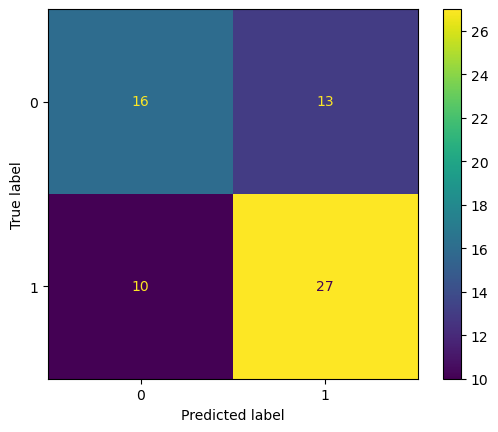

In [20]:
disp.plot()